# This_Is_A_Disaster  
👋 Hello and welcome to the notebook. In this notebook, I make three models and make a submission to the **`nlp-getting-started`** Kaggle compitiion, with each of the model. This project was part of the [Zero-to-Mastery Tensorflow Developer course](https://zerotomastery.io/courses/learn-tensorflow/). The best of these models is then used to make the web app using the Streamlit framework.

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5d5925b1-47c5-2245-0d20-5a0259fe585e)


## Step 0: About the problem 

To predict whether a tweet is regarding a real disaster or not. If it is then mark the tweet as `1` else `0`.   

Files:
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format  

Columns:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real - disaster (1) or not (0)

## Step 1: Get the data  
The data is given officially by the competition organisers on Kaggle.   
- Use Kaggle's API to download the data.
- Get some utility functions which will further help us.
- Configure data files to read using Python.


In [ ]:
# Getting the helper functions script
!wget https://raw.githubusercontent.com/ishandandekar/This_Is_A_Disaster/main/helper_functions.py --no-verbose

# Get the necessary functions
from helper_functions import unzip_data, plot_loss_curves, gen_metrics_report, get_metrics

2022-08-17 09:13:49 URL:https://raw.githubusercontent.com/ishandandekar/This_Is_A_Disaster/main/helper_functions.py [3396/3396] -> "helper_functions.py" [1]


In [ ]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for json to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c nlp-getting-started

# Unzip data
unzip_data("nlp-getting-started.zip")

Saving kaggle.json to kaggle.json
  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 125MB/s]


## Step 2: Know more about the data
- Reading the data using `Pandas` library.
- Get the statistics about the data.
- Check if data is imbalanced.
- Visualizing sample data.
- Split training data into train and validation sets.

In [ ]:
# Importing library
import pandas as pd

# Reading the files in
train_df= pd.read_csv("data/train.csv",index_col=[0])
test_df= pd.read_csv("data/test.csv",index_col=[0])

# Getting the first 5 rows of the training data
train_df.head(5)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Getting a sample from training data
train_df.sample(frac=1,random_state=42).head()

,keyword,location,text,target
id,,,,
3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


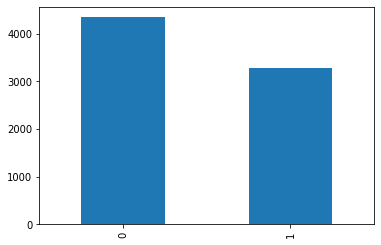

In [ ]:
# Check for label imbalance
train_df.target.value_counts().plot(kind="bar")

In [ ]:
# Check train and test data size
len(train_df),len(test_df)

(7613, 3263)

In [ ]:
# Visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}","(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}")
  print("---\n")

Target: 0 (not real disaster)
Text:
Why did God order obliteration of ancient Canaanites? http://t.co/NLk1DYD2tP
---

Target: 0 (not real disaster)
Text:
Back in 02 to 03 would never said that 50 would have ended ja like obliteration
---

Target: 0 (not real disaster)
Text:
@Eganator2000 There aren't many Obliteration servers but I always like to play when there are :D
---

Target: 0 (not real disaster)
Text:
What a win by Kerry. 7-16..... #obliteration
---

Target: 0 (not real disaster)
Text:
@ashberxo @mind_mischief the removal of all traces of something; obliteration.
---



In [ ]:
# Importing necessary function(s)
from sklearn.model_selection import train_test_split

train_sentences,val_sentences,train_labels,val_labels = train_test_split(train_df["text"].to_numpy(),train_df["target"].to_numpy(),test_size=0.1,random_state=42)

# Check the lengths of the dataframes
print(f"Length of train set: {len(train_sentences)}")
print(f"Length of validation set: {len(val_sentences)}")

Length of train set: 6851
Length of validation set: 762


## Step 3: Building the first model
- Use transfer learning to get a pretrained text-vectorization and embedding layer.
- *(Optional)* Add more layers after the pretrained layer
- Compile the model.
- *(Optional)* Setup `ModelCheckpoint` and `EarlyStopping` callbacks.
- Plot loss curves.
- Make predictions on validation set.
- Make predictions on test set.
- Submit predictions on competition.


In [ ]:
# Get the pretrained embedding layer and using it as a Keras layer
# Using the Universal-Sentence-Encoder, another option is GloVe (pretty famous too)!
import tensorflow_hub as hub
import tensorflow as tf

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype=tf.string,trainable=False,name="USE")

In [ ]:
# Making the model using Sequential API
import tensorflow as tf
from tensorflow.keras import layers

model_0 = tf.keras.Sequential(
    [
     sentence_encoder_layer,
     layers.Dense(64,activation="relu"),
     layers.Dense(1,activation="sigmoid",name="output_layer")
    ],name="model_0_USE"
)

# Compile the model
model_0.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get the summary
model_0.summary()

Model: "model_0_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Setting up variables
EPOCHS = 5

# Create ModelCheckpoint callback to save a model's progress during training
!mkdir -p model_checkpoint/model_0
checkpoint_path = "model_checkpoint/model_0.h5"
mc_callback_0 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Fitting the model on the training set
model_0_history = model_0.fit(train_sentences,
                              train_labels,
                              epochs=EPOCHS,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[mc_callback_0])

Epoch 1/5
215/215 [==============================] - 19s 52ms/step - loss: 0.5061 - accuracy: 0.7851 - val_loss: 0.4288 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.4184 - accuracy: 0.8161 - val_loss: 0.4096 - val_accuracy: 0.8215
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.4049 - accuracy: 0.8213 - val_loss: 0.4032 - val_accuracy: 0.8228
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3966 - accuracy: 0.8267 - val_loss: 0.4032 - val_accuracy: 0.8228
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3895 - accuracy: 0.8286 - val_loss: 0.4026 - val_accuracy: 0.8163


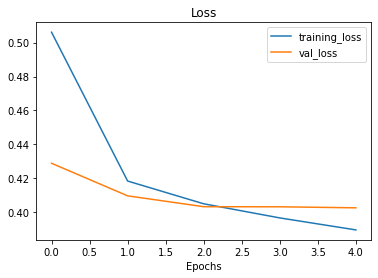

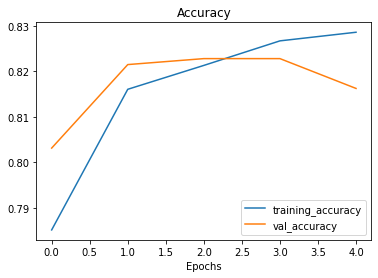

In [ ]:
# Plot loss curves
plot_loss_curves(model_0_history)

In [ ]:
# Load-in best weights saved using checkpoint callback
model_0.load_weights(checkpoint_path)

# Evaluate on the validation data
model_0_pred_probs = model_0.predict(val_sentences)
model_0_preds = tf.squeeze(tf.round(model_0_pred_probs))
get_metrics(val_labels,model_0_preds)

{'accuracy': 82.28346456692913,
 'precision': 0.8236737647868677,
 'recall': 0.8228346456692913,
 'f1': 0.8214628361811204}

In [ ]:
# Checking sample submission to format data for submission
sample = pd.read_csv('data/sample_submission.csv')
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
# Making predictions on test set
test_id,test_sentences = test_df.index,test_df['text']
model_0_pred_probs_test = model_0.predict(test_sentences)
model_0_preds_test = tf.squeeze(tf.round(model_0_pred_probs_test))
submission_0 = pd.DataFrame({'id':test_id,'target':list(map(int,model_2_preds_test))})

In [ ]:
# Submitting the csv to the competition
!mkdir submissions
submission_0.to_csv("submissions/submission_0.csv",index=False)

!kaggle competitions submit -c nlp-getting-started -f submissions/submission_0.csv -m "First submission using model_0"

mkdir: cannot create directory ‘submissions’: File exists
100% 22.2k/22.2k [00:01<00:00, 13.7kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [ ]:
submission_0.head()

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0


## Step 4: Building a better model
- Get a pretrained embedding layer and set `trainable=True`. This trains the parameters within the embedding layer too.
- (Optional) Add more layers to fine-tune.
- Compile the model.
- (Optional) Setup `ModelCheckpoint` and `EarlyStopping` callbacks.
- Plot loss curves.
- Make predictions on validation set.
- Make predictions on test set.
- Submit predictions to competition.

In [ ]:
# Get the pretrained embedding layer and using it as a Keras layer
# Setup trainable as True so the params within this layer can be changed while training
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",input_shape=[],dtype=tf.string,trainable=True,name="USE")

In [ ]:
# Making the model using Sequential API
import tensorflow as tf
from tensorflow.keras import layers

model_1 = tf.keras.Sequential(
    [
     sentence_encoder_layer,
     layers.Dropout(0.2,name="dropout_layer"),
     layers.Dense(64,activation="relu"),
     layers.Dense(1,activation="sigmoid",name="output_layer")
    ],name="model_1_trainable"
)

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get the model summary
model_1.summary()

Model: "model_1_trainable"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_layer (Dropout)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Setting up variables
EPOCHS = 10

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/model_1_cp.ckpt"
mc_callback_1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   monitor="val_accuracy",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=0)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
# Training the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=EPOCHS,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[mc_callback_1,es_callback])

Epoch 1/10
215/215 [==============================] - 55s 228ms/step - loss: 0.4561 - accuracy: 0.7913 - val_loss: 0.4018 - val_accuracy: 0.8320
Epoch 2/10
215/215 [==============================] - 35s 162ms/step - loss: 0.2312 - accuracy: 0.9114 - val_loss: 0.4977 - val_accuracy: 0.8031
Epoch 3/10
215/215 [==============================] - 36s 168ms/step - loss: 0.0851 - accuracy: 0.9723 - val_loss: 0.5827 - val_accuracy: 0.8097


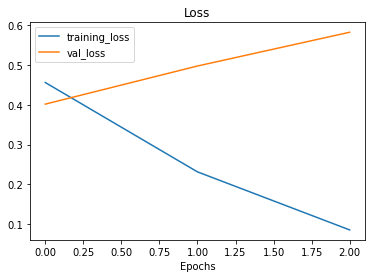

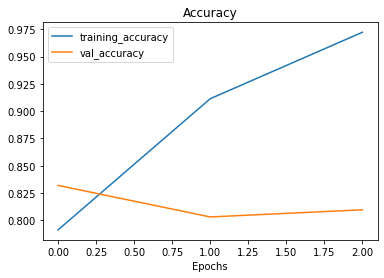

In [ ]:
# Plot loss curves
plot_loss_curves(model_1_history)

Accuracy: 83.2020997375328
Precision: 0.8336802552273471
Recall: 0.8320209973753281
F1-score: 0.8304715515033573


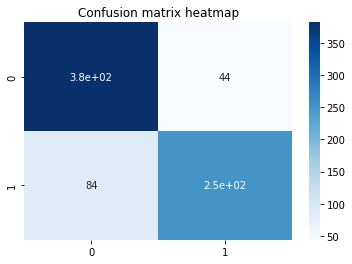

In [ ]:
# Load-in best weights saved using checkpoint callback
model_1.load_weights(checkpoint_path)

# Evaluate on the validation data
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
gen_metrics_report(val_labels,model_1_preds)

In [ ]:
# Making predictions on test set
model_1_pred_probs_test = model_1.predict(test_sentences)
model_1_preds_test = tf.squeeze(tf.round(model_1_pred_probs_test))
submission_1 = pd.DataFrame({'id':test_id,'target':list(map(int,model_1_preds_test))})

In [ ]:
# Making submission to the competition
submission_0.to_csv("submissions/submission_1.csv",index=False)

!kaggle competitions submit -c nlp-getting-started -f submissions/submission_1.csv -m "Second submission using model_1"

100% 22.2k/22.2k [00:01<00:00, 11.6kB/s]
400 - Bad Request


## Step 5: Building a *better* better model
- Get the same model in **step 5**.
- Add callbacks.
- Train the model on whole training set (training set before split).
- Make predictions on test set.
- Submit predictions on competition.

In [ ]:
# Cloning model_1
model_2 = tf.keras.models.clone_model(model_1)

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get the model summary
model_2.summary()

Model: "model_1_trainable"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_layer (Dropout)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Setting up variables
EPOCHS = 10

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/model_2_cp.ckpt"
mc_callback_2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   monitor="loss",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=0)

es_callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [ ]:
# Formatting train data
train_sentences_full,train_labels_full = train_df["text"],train_df["target"]

In [ ]:
# Training the model
model_2_history = model_2.fit(train_sentences_full,
                              train_labels_full,
                              epochs=EPOCHS,
                              callbacks=[mc_callback_2,es_callback])

Epoch 1/10
238/238 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7935

238/238 [==============================] - 56s 211ms/step - loss: 0.4570 - accuracy: 0.7935
Epoch 2/10
238/238 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9040

238/238 [==============================] - 50s 208ms/step - loss: 0.2431 - accuracy: 0.9040
Epoch 3/10
238/238 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9718

238/238 [==============================] - 50s 210ms/step - loss: 0.0835 - accuracy: 0.9718
Epoch 4/10
238/238 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9856

238/238 [==============================] - 50s 209ms/step - loss: 0.0412 - accuracy: 0.9856
Epoch 5/10
238/238 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9883

238/238 [==============================] - 49s 208ms/step - loss: 0.0285 - accuracy: 0.9883
Epoch 6/10
238/238 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9923

238/238 [==============================] - 49s 207ms/step - loss: 0.0202 - accuracy: 0.9923
Epoch 7/10
238/238 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9926

238/238 [==============================] - 50s 209ms/step - loss: 0.0149 - accuracy: 0.9926
Epoch 8/10
238/238 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9945

238/238 [==============================] - 50s 210ms/step - loss: 0.0125 - accuracy: 0.9945
Epoch 9/10
238/238 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9954

238/238 [==============================] - 49s 208ms/step - loss: 0.0094 - accuracy: 0.9954
Epoch 10/10
238/238 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9944

238/238 [==============================] - 36s 152ms/step - loss: 0.0108 - accuracy: 0.9944


In [ ]:
# Plot loss curves
# plot_loss_curves(model_2_history)

KeyError: ignored

In [ ]:
# Load-in best weights saved using checkpoint callback
model_2.load_weights(checkpoint_path)

In [ ]:
# Making predictions on test set
model_2_pred_probs_test = model_2.predict(test_sentences)
model_2_preds_test = tf.squeeze(tf.round(model_2_pred_probs_test))
submission_2 = pd.DataFrame({'id':test_id,'target':list(map(int,model_2_preds_test))})

In [ ]:
# Making submission to the competition
submission_2.to_csv("submissions/submission_2.csv",index=False)

!kaggle competitions submit -c nlp-getting-started -f submissions/submission_2.csv -m "Third submission using model_2"

100% 22.2k/22.2k [00:01<00:00, 13.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Step 6: Comparing the two models' results
- Check the results on Kaggle's website
- Analyze results
- How to improve these
